In [1]:
magma_dir = '/home/marco/epfl/magma/'
transformers_dir = '/home/marco/epfl/transformers/'

#### AWS

In [ ]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

sys.path.insert(0, transformers_dir+'examples/seq2seq/')
import utils

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'fine-tuning/gps_bart_para_wordembed/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [ ]:
data_dir = bucket_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
from transformers import EvalPrediction

tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_or_path, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, n_examples=5):
    
    df_examples = df_val.sample(n_examples, axis='index', random_state=config.SEED)
    
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
            
        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt', truncation=True).to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print('Prediction\n%s (%d tok):\n'%(model_name_or_path, summ_num_tok))
        print(fill(summ, 100))
        print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Compute Metrics

In [8]:
def compute_metrics(model_name_or_path, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, batch_size=8):
    
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    summarization_metrics = utils.build_compute_metrics_fn('summarization', tokenizer)

    input_ids = tokenizer(df_val.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)
    
    reference_ids = tokenizer(df_val.bullets.tolist(), return_tensors='pt', padding=True).input_ids
    reference_ids = reference_ids.split(batch_size)
    
    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    metrics_final = {}
    avg_len = len(input_ids)
    
    for batch, label_ids in zip(input_ids, reference_ids):

        pred_ids = model.generate(
            batch.to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)
        ep = EvalPrediction(pred_ids, label_ids)
        
        metrics = summarization_metrics(ep)
        for k in metrics.keys():
            if k not in metrics_final:
                metrics_final[k] = 0
            metrics_final[k] += (metrics[k] / avg_len)

        pbar.update(1)
    pbar.close()
    return metrics_final

## **Sentence-Transformers**

In [9]:
data_dir_st = data_dir + 'st/base/'

In [10]:
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])

### **Generative Parameter Search**

In [11]:
model_name_or_path =  magma_dir+'fine-tuning/ft_bart_para_wordembed/checkpoint-196'

In [12]:
min_length_swipe = [10, 20, 30]
max_length_swipe = [110, 120, 130]
length_penalty_swipe = [0, 1, 2]
no_repeat_ngram_size_swipe = [2, 3, 4]

In [13]:
gps_metrics = pd.DataFrame(columns=['min_length', 'max_length', 'length_penalty', 'no_repeat_ngram',
                     'r1_precision', 'r1_recall', 'r1_fmeasure',
                     'r2_precision', 'r2_recall', 'r2_fmeasure',
                     'rL_precision', 'rL_recall', 'rL_fmeasure',
                     'ST', 'W2V'])

In [19]:
idx = 0
max_trials = len(min_length_swipe)+len(max_length_swipe)+len(length_penalty_swipe)+len(no_repeat_ngram_size_swipe)
for min_length in min_length_swipe:
    for max_length in max_length_swipe:
        for length_penalty in length_penalty_swipe:
            for no_repeat_ngram_size in no_repeat_ngram_size_swipe:
                
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print('###\t\t\t\t###')
                print('### \tMIN LENGTH: %d\t\t###'%min_length)
                print('### \tMAX LENGTH: %d\t\t###'%max_length)
                print('### \tLENGTH PENALTY: %d\t###'%length_penalty)
                print('### \tNO REPEAT NGRAM: %d\t###'%no_repeat_ngram_size)
                print('### \tPROGRESS: %.2f %%\t###'%(100*round(idx/max_trials, 4)))
                print('###\t\t\t\t###')
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print()
                
                metrics = compute_metrics(model_name_or_path, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)
                
                gps_metrics.loc[idx] = [min_length, max_length, length_penalty, no_repeat_ngram_size]+\
                    [metrics[k] for k in metrics if 'sum' not in k and 'len' not in k]
                
                idx += 1
                
                print()
                print_examples(model_name_or_path, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 110		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 0.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.




(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
sshleifer/bart-tiny-random (110 tok):

 up Trend 

Prediction
sshleifer/bart-tiny-random (110 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these

Prediction
sshleifer/bart-tiny-random (120 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassert

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancer

Prediction
sshleifer/bart-tiny-random (130 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassertassertateredatered 291 291 SQ Gender Genderatered Wireless

Reference:
Management of both local and distant metastatic disease should be considered.

################################################################################

Prediction
sshleifer/bart-tiny-random (110 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and 

Prediction
sshleifer/bart-tiny-random (120 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassert

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

################################################################################################

Prediction
sshleifer/bart-tiny-random (130 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassertassertateredatered 291 291 SQ Gender Genderatered Wireless

Reference:
Radiotherapy and temozolomide is suitable for fit elderly patients with glioblastoma.

########################################################################

Prediction
sshleifer/bart-tiny-random (110 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(978

100%|██████████| 34/34 [01:19<00:00,  2.32s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
ss

Prediction
sshleifer/bart-tiny-random (120 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassert

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancer

Prediction
sshleifer/bart-tiny-random (130 tok):

 up Trend Trenddeepdeep Trudeau Trudeau Render Render Union mixing mixingraryrary__ozyozyaddonaddon
Afterwards AfterwardsGrGrannonannonQuiteQuite Floatinglocklock 141 141 envis envis warmth warmth
balls balls Polar Polar 01 01 escalated escalatedUSUS Bowser SUB SUBirledirled grievances grievances
eject eject scheduling scheduling manipulate manipulate southeastern southeastern toxicity toxicity
\ \GRGR fever fever Humans HumansblblotionalotionalSignSignbringingbringing akin akin wart wart
Childhood Childhood Lorenzo obliviousappendappend shelter shelterufferufferracial Oliv Oliv
HELuguugu patented patented incess incess Rover incess scheduling inund inund scheduling Stick Stick
VR VRcécé instruct instructassertassertateredatered 291 291 SQ Gender Genderatered Wireless

Reference:
Management of both local and distant metastatic disease should be considered.

################################################################################

In [20]:
gps_metrics.to_csv(OUTPUT_PATH+'df.csv')

In [22]:
gps_metrics

,min_length,max_length,length_penalty,no_repeat_ngram,r1_precision,r1_recall,r1_fmeasure,r2_precision,r2_recall,r2_fmeasure,rL_precision,rL_recall,rL_fmeasure,ST,W2V
0,10.0,110.0,0.0,2.0,0.074118,0.138529,0.094118,0.0,0.0,0.0,0.074118,0.138529,0.094118,7.917789,73.478703
1,10.0,120.0,0.0,2.0,0.095588,0.265294,0.135588,0.0,0.0,0.0,0.095588,0.265294,0.135588,6.888374,78.449445
2,10.0,130.0,0.0,2.0,0.089412,0.265294,0.128235,0.0,0.0,0.0,0.089412,0.265294,0.128235,7.271219,81.531200
3,20.0,110.0,0.0,2.0,0.074118,0.138529,0.094118,0.0,0.0,0.0,0.074118,0.138529,0.094118,7.917789,73.478703
4,20.0,120.0,0.0,2.0,0.095588,0.265294,0.135588,0.0,0.0,0.0,0.095588,0.265294,0.135588,6.888374,78.449445
5,20.0,130.0,0.0,2.0,0.089412,0.265294,0.128235,0.0,0.0,0.0,0.089412,0.265294,0.128235,7.271219,81.531200
6,30.0,110.0,0.0,2.0,0.074118,0.138529,0.094118,0.0,0.0,0.0,0.074118,0.138529,0.094118,7.917789,73.478703
7,30.0,120.0,0.0,2.0,0.095588,0.265294,0.135588,0.0,0.0,0.0,0.095588,0.265294,0.135588,6.888374,78.449445
8,30.0,130.0,0.0,2.0,0.089412,0.265294,0.128235,0.0,0.0,0.0,0.089412,0.265294,0.128235,7.271219,81.531200


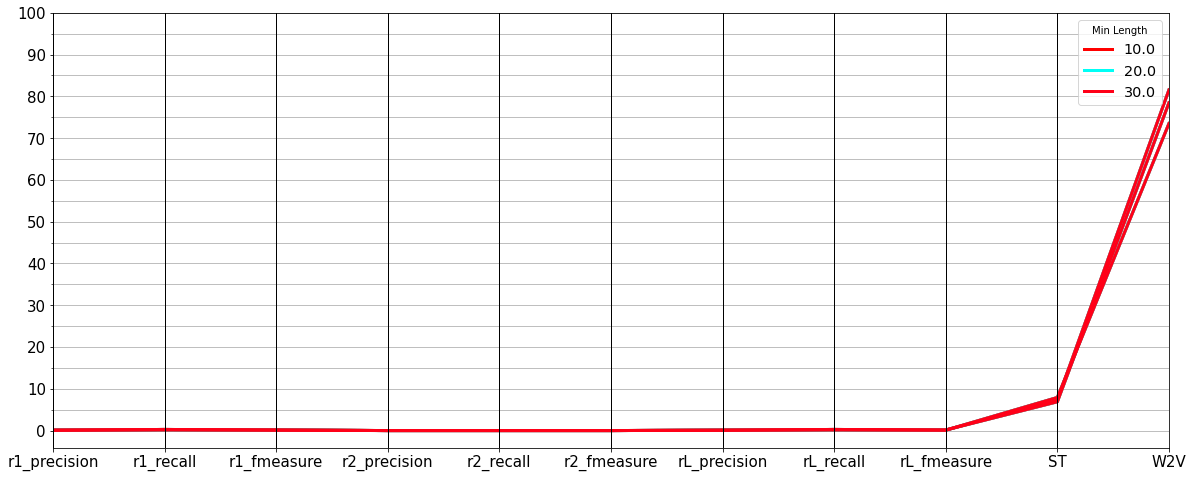

In [23]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
pd.plotting.parallel_coordinates(
    gps_metrics,
    'min_length',
    [c for c in gps_metrics.columns if 'r1' in c or 'r2' in c or 'rL' in c or 'ST' in c or 'W2V' in c],
    ax = ax,
    colormap='hsv',
    linewidth=3,
)
ax.set_yticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 21), minor=True)
for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(15)
for t in ax.yaxis.get_major_ticks():
    t.label.set_fontsize(15)
    
ax.grid(True, which='both')

ax.legend(title='Min Length', fontsize='x-large')

plt.show()